In [2]:
import os
import random
import pickle
import numpy as np
random.seed(42)
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50, InceptionV3, Xception,
    MobileNet, MobileNetV2, MobileNetV3Large, DenseNet121, DenseNet169, NASNetMobile,
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB7
)
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping

import time
import pandas as pd
from tensorflow.keras.models import load_model

import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
with open("/content/drive/MyDrive/Master - A/june_muchomor_sromotnikowy_12500.pkl", "rb") as f:
    X_muchomor = pickle.load(f)
with open("/content/drive/MyDrive/Master - A/june_kania_12500.pkl", "rb") as f:
    X_kania = pickle.load(f)

labels_muchomory = list(np.zeros(len(X_muchomor)))
labels_kania = list(np.ones(len((X_kania))))

In [5]:
from sklearn.utils import shuffle

X = np.array(X_kania + X_muchomor)
y = np.array(labels_kania + labels_muchomory)

#X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.reshape(-1, 224, 224, 3).astype('float32') / 255.0
X_test = X_test.reshape(-1, 224, 224, 3).astype('float32') / 255.0

del X, y, X_muchomor, labels_muchomory, X_kania, labels_kania


#CNN

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 70


model_classes = [
    InceptionV3, Xception, MobileNet,MobileNetV2,
    DenseNet121, VGG16
]

model_names = [
    "InceptionV3", "Xception", "MobileNet", "MobileNetV2",
    "DenseNet121", "VGG16"
]



In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def my_cnn(input_shape=(224, 224, 3), num_classes=1):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model



In [ ]:
model_classes = [

]

model_names = [

]
for model_class, name in zip(model_classes, model_names):
  print(name)

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

def cnn_sim(x_train, x_test, y_train, y_test, param):
    results = []

    for model_class, name in zip(model_classes, model_names):
        print(f"\n{name}")

        base_model = model_class(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(
            x_train, y_train,
            epochs=70,
            batch_size=64,
            validation_split=0.2,
            verbose=2,
            callbacks=[early_stopping]
        )
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        loss, acc = model.evaluate(x_test, y_test)
        print(f"{name} - Test accuracy: {acc:.4f}")

        y_prob = model.predict(x_test)
        y_pred = (y_prob > 0.5).astype("int32")

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
        plt.close()

        model.save(f'/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_model.h5')

        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs', fontsize = 18)
        plt.ylabel('Loss', fontsize = 18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend()
        #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
        plt.close()

        plt.figure(figsize=(8, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs',fontsize = 18)
        plt.ylabel('Accuracy',fontsize = 18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend()
        #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
        plt.close()

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate', fontsize = 18)
        plt.ylabel('True Positive Rate', fontsize = 18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        #plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
        plt.close()

        results.append({
            'Model': name,
            'Test Accuracy': acc,
            'Training Time (s)': training_time
        })

    model = my_cnn()
    name = "my"

    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=70, batch_size=32,
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")
    test_loss, test_acc = model.evaluate(x_test, y_test)
    loss, acc = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")
    y_prob = model.predict(x_test)
    y_pred = (y_prob > 0.5).astype("int32")
    onf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
    plt.close()

    model.save(f'/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_model.h5')

    file_path = f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_history.pkl"
    with open(file_path, 'wb') as f:
      pickle.dump(history.history, f)

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend()
    #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize = 18)
    plt.ylabel('Accuracy', fontsize =18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend()
    #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
    plt.close()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize =18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    #plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
    plt.close()

    results.append({
        'Model': name,
        'Test Accuracy': acc,
        'Training Time (s)': training_time
    })

    results_df = pd.DataFrame(results)
    results_df.to_csv(f'/content/drive/MyDrive/Master - A/2_fig/2_{param}_model_training_results.csv', index=False)
    print(results_df)
cnn_sim(X_train[:16000], X_test, y_train[:16000], y_test, 16000)



InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 41s - 207ms/step - accuracy: 0.8687 - loss: 0.3028 - val_accuracy: 0.9203 - val_loss: 0.1997
Epoch 2/70
200/200 - 11s - 55ms/step - accuracy: 0.9153 - loss: 0.2081 - val_accuracy: 0.9197 - val_loss: 0.1978
Epoch 3/70
200/200 - 11s - 55ms/step - accuracy: 0.9216 - loss: 0.1939 - val_accuracy: 0.9231 - val_loss: 0.1954
Epoch 4/70
200/200 - 11s - 56ms/step - accuracy: 0.9275 - loss: 0.1825 - val_accuracy: 0.9275 - val_loss: 0.1785
Epoch 5/70
200/200 - 11s - 56ms/step - accuracy: 0.9318 - loss: 0.1703 - val_accuracy: 0.9303 - val_loss: 0.1720
Epoch 6/70
200/200 - 11s - 55ms/step - accuracy: 0.9317 - loss: 0.1722 - val_accuracy: 0.9303 - val_loss: 0.1834
Epoch 7/70
200/200 - 11s - 56ms/step - accuracy: 0.9355 - loss: 0.1653 - val_accuracy: 0.9297 - val_loss: 0.1740
Epoch 8/70
200/200 - 11s - 56ms/step - accuracy: 0.9388 - loss: 0.1548 - val_accuracy: 0.9334 - val_loss: 0.1689
Epoch 9/70
200/200 - 11s - 56ms


Xception
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 46s - 230ms/step - accuracy: 0.8805 - loss: 0.2780 - val_accuracy: 0.9141 - val_loss: 0.2099
Epoch 2/70
200/200 - 23s - 117ms/step - accuracy: 0.9162 - loss: 0.2033 - val_accuracy: 0.9159 - val_loss: 0.2039
Epoch 3/70
200/200 - 23s - 117ms/step - accuracy: 0.9259 - loss: 0.1830 - val_accuracy: 0.9225 - val_loss: 0.1858
Epoch 4/70
200/200 - 23s - 117ms/step - accuracy: 0.9327 - loss: 0.1728 - val_accuracy: 0.9247 - val_loss: 0.1815
Epoch 5/70
200/200 - 23s - 117ms/step - accuracy: 0.9391 - loss: 0.1574 - val_accuracy: 0.9291 - val_loss: 0.1774
Epoch 6/70
200/200 - 23s - 117ms/step - accuracy: 0.9405 - loss: 0.1480 - val_accuracy: 0.9297 - val_loss: 0.1781
Epoch 7/70
200/200 - 23s - 117ms/step - accuracy: 0.9424 - loss: 0.1437 - val_accuracy: 0.9256 - val_loss: 0.1813
Epoch 8/70
200/200 - 23s - 117ms/step - accuracy: 0.9490 - loss: 0.1311 - val_accuracy: 0.9359 - val_loss: 0.1653
Epoch 9/70
200/200 - 23s - 

Accuracy: 0.9354

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      2499
         1.0       0.93      0.94      0.94      2498

    accuracy                           0.94      4997
   macro avg       0.94      0.94      0.94      4997
weighted avg       0.94      0.94      0.94      4997


MobileNet
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 23s - 113ms/step - accuracy: 0.8958 - loss: 0.2481 - val_accuracy: 0.9334 - val_loss: 0.1785
Epoch 2/70
200/200 - 8s - 41ms/step - accuracy: 0.9341 - loss: 0.1697 - val_accuracy: 0.9388 - val_loss: 0.1539
Epoch 3/70
200/200 - 8s - 41ms/step - accuracy: 0.9385 - loss: 0.1516 - val_accuracy: 0.9306 - val_loss: 0.1655
Epoch 4/70
200/200 - 8s - 41ms/step - accuracy: 0.9466 - loss: 0.1364 - val_accuracy: 0.9262 - val_loss: 0.1826
Epoch 5/70
200/200 - 8s - 41ms/step - accuracy: 0.9524 - loss: 0.1244 - val_accuracy: 0.9447 - val_loss: 0.1344
Epoch 6/


MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 28s - 140ms/step - accuracy: 0.8971 - loss: 0.2495 - val_accuracy: 0.9306 - val_loss: 0.1849
Epoch 2/70
200/200 - 10s - 48ms/step - accuracy: 0.9276 - loss: 0.1863 - val_accuracy: 0.9316 - val_loss: 0.1749
Epoch 3/70
200/200 - 10s - 48ms/step - accuracy: 0.9339 - loss: 0.1672 - val_accuracy: 0.9409 - val_loss: 0.1624
Epoch 4/70
200/200 - 10s - 48ms/step - accuracy: 0.9393 - loss: 0.1491 - val_accuracy: 0.9413 - val_loss: 0.1596
Epoch 5/70
200/200 - 10s - 48ms/step - accuracy: 0.9440 - loss: 0.1414 - val_accuracy: 0.9381 - val_loss: 0.1705
Epoch 6/70
200/200 - 10s - 48ms/step - accuracy: 0.9500 - loss: 0.1309 - val_accuracy: 0.9425 - val_loss: 0.1590
Epoch 7/70
200/200 - 10s - 48ms/step - accuracy: 0.9521 - loss: 0.1197 - val_accuracy: 0.9441 - val_loss: 0.1546
Epoch 8/70
200/200 - 10s - 48ms/step - accuracy: 0.9559 - loss: 0.1111 - val_accuracy: 0.9453 - val_loss: 0.1534
Epoch 9/70
200/200 - 10s - 49ms/s

Accuracy: 0.9462

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      2499
         1.0       0.95      0.94      0.95      2498

    accuracy                           0.95      4997
   macro avg       0.95      0.95      0.95      4997
weighted avg       0.95      0.95      0.95      4997


DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 61s - 304ms/step - accuracy: 0.8910 - loss: 0.2573 - val_accuracy: 0.9334 - val_loss: 0.1708
Epoch 2/70
200/200 - 19s - 97ms/step - accuracy: 0.9304 - loss: 0.1764 - val_accuracy: 0.9400 - val_loss: 0.1460
Epoch 3/70
200/200 - 19s - 97ms/step - accuracy: 0.9409 - loss: 0.1547 - val_accuracy: 0.9434 - val_loss: 0.1369
Epoch 4/70
200/200 - 19s - 95ms/step - accuracy: 0.9444 - loss: 0.1421 - val_accuracy: 0.9438 - val_loss: 0.1423
Epoch 5/70
200/200 - 19s - 95ms/step - accuracy: 0.9480 - loss: 0.1356 - val_accuracy: 0.9403 - val_loss: 0.1413
Ep

Accuracy: 0.9498

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      2499
         1.0       0.95      0.95      0.95      2498

    accuracy                           0.95      4997
   macro avg       0.95      0.95      0.95      4997
weighted avg       0.95      0.95      0.95      4997


VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 61s - 307ms/step - accuracy: 0.7484 - loss: 0.5154 - val_accuracy: 0.8413 - val_loss: 0.3904
Epoch 2/70
200/200 - 37s - 184ms/step - accuracy: 0.8339 - loss: 0.3816 - val_accuracy: 0.8009 - val_loss: 0.4308
Epoch 3/70
200/200 - 37s - 186ms/step - accuracy: 0.8505 - loss: 0.3539 - val_accuracy: 0.8675 - val_loss: 0.3263
Epoch 4/70
200/200 - 37s - 186ms/step - accuracy: 0.8587 - loss: 0.3344 - val_accuracy: 0.8684 - val_loss: 0.3193
Epoch 5/70
200/200 - 37s - 185ms/step - accuracy: 0.8648 - loss: 0.3185 - val_accuracy: 0.8728 - val_loss: 0.3081
Epoc

Accuracy: 0.8883

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      2499
         1.0       0.88      0.90      0.89      2498

    accuracy                           0.89      4997
   macro avg       0.89      0.89      0.89      4997
weighted avg       0.89      0.89      0.89      4997



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.6025 - loss: 0.7236 - val_accuracy: 0.7803 - val_loss: 0.4787
Epoch 2/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.7861 - loss: 0.4718 - val_accuracy: 0.8112 - val_loss: 0.4202
Epoch 3/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8290 - loss: 0.3989 - val_accuracy: 0.8006 - val_loss: 0.4377
Epoch 4/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8476 - loss: 0.3567 - val_accuracy: 0.8628 - val_loss: 0.3217
Epoch 5/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8682 - loss: 0.3154 - val_accuracy: 0.8556 - val_loss: 0.3349
Epoch 6/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8840 - loss: 0.2698 - val_accuracy: 0.8669 - val_loss: 0.3324
Epoch 7/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.8989 - loss: 0.2381 - val_accuracy: 0.8706 - val_loss: 0.3521
Epoch 8/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9183 - loss: 0.1991 - 

         Model  Test Accuracy  Training Time (s)
0  InceptionV3       0.928557         196.160708
1     Xception       0.935361         429.139114
2    MobileNet       0.951371         145.470308
3  MobileNetV2       0.946168         180.337510
4  DenseNet121       0.949770         450.929835
5        VGG16       0.888333        1218.768974
6           my       0.864919         168.803613


In [ ]:
x_train = X_train[:12000]
x_test = X_test
y_train = y_train[:12000]
y_test = y_test
model = my_cnn()
name = "my"

start_time = time.time()
history = model.fit(x_train, y_train, epochs=70, batch_size=32,
                validation_split=0.2, verbose=1, callbacks=[early_stopping])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")
test_loss, test_acc = model.evaluate(x_test, y_test)
loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
y_prob = model.predict(x_test)
y_pred = (y_prob > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
plt.close()

# Zapisz model
model.save(f'/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_model.h5')

file_path = f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_history.pkl"
with open(file_path, 'wb') as f:
  pickle.dump(history.history, f)

# Train vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
plt.close()

# Train vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title(f'ROC Curve - {name}')
plt.legend(loc="lower right")
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
plt.close()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.6139 - loss: 0.7218 - val_accuracy: 0.7983 - val_loss: 0.4378
Epoch 2/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8066 - loss: 0.4267 - val_accuracy: 0.7962 - val_loss: 0.4352
Epoch 3/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8286 - loss: 0.3906 - val_accuracy: 0.8171 - val_loss: 0.4063
Epoch 4/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8608 - loss: 0.3313 - val_accuracy: 0.8233 - val_loss: 0.3847
Epoch 5/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8851 - loss: 0.2816 - val_accuracy: 0.8050 - val_loss: 0.4581
Epoch 6/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9067 - loss: 0.2241 - val_accuracy: 0.8417 - val_loss: 0.4126
Epoch 7/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9303 - loss: 0.1749 - val_accuracy: 0.8267 - val_loss: 0.5224
Epoch 8/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.9499 - loss: 0.1171 - 

In [ ]:
param ="testtttt"
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
plt.close()

# Zapisz model
model.save(f'/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_model.h5')

file_path = f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_history.pkl"
with open(file_path, 'wb') as f:
  pickle.dump(history.history, f)

# Train vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
plt.close()

# Train vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(f'ROC Curve - {name}')
plt.legend(loc="lower right")
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
plt.close()

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

def cnn_sim(x_train, x_test, y_train, y_test, param):
    results = []

    for model_class, name in zip(model_classes, model_names):
        print(f"\n{name}")

        base_model = model_class(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        base_model.trainable = False

        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        history = model.fit(
            x_train, y_train,
            epochs=70,
            batch_size=64,
            validation_split=0.2,
            verbose=2,
            callbacks=[early_stopping]
        )
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")
        loss, acc = model.evaluate(x_test, y_test)
        print(f"{name} - Test accuracy: {acc:.4f}")

        y_prob = model.predict(x_test)
        y_pred = (y_prob > 0.5).astype("int32")

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
        plt.close()

        model.save(f'/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_model.h5')

        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs', fontsize = 18)
        plt.ylabel('Loss', fontsize = 18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend()
        plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
        plt.close()

        plt.figure(figsize=(8, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs',fontsize = 18)
        plt.ylabel('Accuracy',fontsize = 18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend()
        plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
        plt.close()

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate', fontsize = 18)
        plt.ylabel('True Positive Rate', fontsize = 18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        #plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
        plt.close()

        results.append({
            'Model': name,
            'Test Accuracy': acc,
            'Training Time (s)': training_time
        })

    model = my_cnn()
    name = "my"

    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=70, batch_size=32,
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")
    test_loss, test_acc = model.evaluate(x_test, y_test)
    loss, acc = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")
    y_prob = model.predict(x_test)
    y_pred = (y_prob > 0.5).astype("int32")
    onf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
    plt.close()

    model.save(f'/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_model.h5')

    file_path = f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_history.pkl"
    with open(file_path, 'wb') as f:
      pickle.dump(history.history, f)

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize = 18)
    plt.ylabel('Accuracy', fontsize =18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend()
    plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
    plt.close()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize = 18)
    plt.ylabel('True Positive Rate', fontsize =18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
    plt.close()

    results.append({
        'Model': name,
        'Test Accuracy': acc,
        'Training Time (s)': training_time
    })

    results_df = pd.DataFrame(results)
    results_df.to_csv(f'/content/drive/MyDrive/Master - A/2_fig/{param}_model_training_results.csv', index=False)
    print(results_df)



In [ ]:
print(y_train.shape)
print(y_test.shape)

(19986,)
(4997,)


# 6000


In [ ]:
cnn_sim(X_train[:12000], X_test, y_train[:12000], y_test, 12000)


InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/70
150/150 - 46s - 308ms/step - accuracy: 0.8678 - loss: 0.3086 - val_accuracy: 0.9167 - val_loss: 0.2056
Epoch 2/70
150/150 - 8s - 55ms/step - accuracy: 0.9139 - loss: 0.2136 - val_accuracy: 0.9262 - val_loss: 0.1805
Epoch 3/70
150/150 - 8s - 54ms/step - accuracy: 0.9252 - loss: 0.1929 - val_accuracy: 0.9250 - val_loss: 0.1831
Epoch 4/70
150/150 - 8s - 56ms/step - accuracy: 0.9293 - loss: 0.1843 - val_accuracy: 0.9254 - val_loss: 0.1785
Epoch 5/70
150/150 - 8s - 56ms/step - accuracy: 0.9321 - loss: 0.1740 - val_accuracy: 0.9321 - val_loss: 0.1774
Epoch 6/70
150/150 - 8s - 56ms/step - accuracy: 0.9361 - loss: 0.1621 - val_accuracy: 0.9312 - val_loss: 0.1737
Epoch 7/70
150/150 - 8s - 55ms/step - accuracy: 0.9382 - loss: 0.1584 - val_accuracy: 0.9271 - val_loss: 0.1784
Epoch 8/70
150/150 - 8s - 55ms/step - accuracy: 0.9396 - loss: 0.1526 - val_accuracy: 0.9254 - val_loss: 0.1876
Epoch 9/70
150/150 - 9s - 57ms/step - 


Xception
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/70
150/150 - 46s - 304ms/step - accuracy: 0.8794 - loss: 0.2847 - val_accuracy: 0.9096 - val_loss: 0.2236
Epoch 2/70
150/150 - 18s - 120ms/step - accuracy: 0.9130 - loss: 0.2119 - val_accuracy: 0.9208 - val_loss: 0.2046
Epoch 3/70
150/150 - 18s - 119ms/step - accuracy: 0.9232 - loss: 0.1907 - val_accuracy: 0.9212 - val_loss: 0.2013
Epoch 4/70
150/150 - 18s - 119ms/step - accuracy: 0.9331 - loss: 0.1717 - val_accuracy: 0.9246 - val_loss: 0.1863
Epoch 5/70
150/150 - 18s - 118ms/step - accuracy: 0.9348 - loss: 0.1630 - val_accuracy: 0.9158 - val_loss: 0.2107
Epoch 6/70
150/150 - 18s - 119ms/step - accuracy: 0.9392 - loss: 0.1535 - val_accuracy: 0.9292 - val_loss: 0.1821
Epoch 7/70
150/150 - 18s - 118ms/step - accuracy: 0.9449 - loss: 0.1385 - val_accuracy: 0.9262 - val_loss: 0.1882
Epoch 8/70
150/150 - 18s - 118ms/step - accuracy: 0.9493 - loss: 0.1298 - val_accuracy: 0.9258 - val_loss: 0.1926
Epoch 9/70
150/150 - 18s - 


MobileNet
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/70
150/150 - 24s - 162ms/step - accuracy: 0.8814 - loss: 0.2776 - val_accuracy: 0.9325 - val_loss: 0.1639
Epoch 2/70
150/150 - 6s - 42ms/step - accuracy: 0.9295 - loss: 0.1800 - val_accuracy: 0.9362 - val_loss: 0.1635
Epoch 3/70
150/150 - 6s - 42ms/step - accuracy: 0.9377 - loss: 0.1523 - val_accuracy: 0.9425 - val_loss: 0.1519
Epoch 4/70
150/150 - 6s - 41ms/step - accuracy: 0.9451 - loss: 0.1391 - val_accuracy: 0.9433 - val_loss: 0.1418
Epoch 5/70
150/150 - 6s - 42ms/step - accuracy: 0.9510 - loss: 0.1297 - val_accuracy: 0.9371 - val_loss: 0.1584
Epoch 6/70
150/150 - 6s - 42ms/step - accuracy: 0.9536 - loss: 0.1181 - val_accuracy: 0.9446 - val_loss: 0.1426
Epoch 7/70
150/150 - 6s - 42ms/step - accuracy: 0.9601 - loss: 0.1057 - val_accuracy: 0.9467 - val_loss: 0.1374
Epoch 8/70
150/150 - 6s - 42ms/step - accuracy: 0.9596 - loss: 0.1037 - val_accuracy: 0.9237 - val_loss: 0.1870
Epoch 9/70
150/150 - 6s - 42ms/step - ac


MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/70
150/150 - 30s - 201ms/step - accuracy: 0.8894 - loss: 0.2636 - val_accuracy: 0.9279 - val_loss: 0.1859
Epoch 2/70
150/150 - 7s - 49ms/step - accuracy: 0.9266 - loss: 0.1879 - val_accuracy: 0.9342 - val_loss: 0.1727
Epoch 3/70
150/150 - 7s - 48ms/step - accuracy: 0.9326 - loss: 0.1720 - val_accuracy: 0.9233 - val_loss: 0.1769
Epoch 4/70
150/150 - 7s - 48ms/step - accuracy: 0.9413 - loss: 0.1500 - val_accuracy: 0.9346 - val_loss: 0.1672
Epoch 5/70
150/150 - 7s - 48ms/step - accuracy: 0.9464 - loss: 0.1373 - val_accuracy: 0.9362 - val_loss: 0.1689
Epoch 6/70
150/150 - 7s - 48ms/step - accuracy: 0.9531 - loss: 0.1251 - val_accuracy: 0.9262 - val_loss: 0.1795
Epoch 7/70
150/150 - 7s - 48ms/step - accuracy: 0.9570 - loss: 0.1151 - val_accuracy: 0.9404 - val_loss: 0.1665
Epoch 8/70
150/150 - 7s - 47ms/step - accuracy: 0.9607 - loss: 0.1032 - val_accuracy: 0.9354 - val_loss: 0.1726
Epoch 9/70
150/150 - 7s - 48ms/step - ac


DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/70
150/150 - 67s - 447ms/step - accuracy: 0.8820 - loss: 0.2751 - val_accuracy: 0.9258 - val_loss: 0.1756
Epoch 2/70
150/150 - 15s - 97ms/step - accuracy: 0.9294 - loss: 0.1844 - val_accuracy: 0.9354 - val_loss: 0.1554
Epoch 3/70
150/150 - 15s - 97ms/step - accuracy: 0.9406 - loss: 0.1548 - val_accuracy: 0.9388 - val_loss: 0.1491
Epoch 4/70
150/150 - 14s - 96ms/step - accuracy: 0.9436 - loss: 0.1453 - val_accuracy: 0.9312 - val_loss: 0.1584
Epoch 5/70
150/150 - 15s - 97ms/step - accuracy: 0.9452 - loss: 0.1393 - val_accuracy: 0.9383 - val_loss: 0.1469
Epoch 6/70
150/150 - 15s - 97ms/step - accuracy: 0.9498 - loss: 0.1275 - val_accuracy: 0.9371 - val_loss: 0.1514
Epoch 7/70
150/150 - 15s - 97ms/step - accuracy: 0.9524 - loss: 0.1230 - val_accuracy: 0.9337 - val_loss: 0.1561
Epoch 8/70
150/150 - 14s - 96ms/step - accuracy: 0.9554 - loss: 0.1132 - val_accuracy: 0.9421 - val_loss: 0.1491
Epoch 9/70
150/150 - 14s - 96ms


VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/70
150/150 - 63s - 419ms/step - accuracy: 0.7283 - loss: 0.5400 - val_accuracy: 0.8263 - val_loss: 0.4250
Epoch 2/70
150/150 - 28s - 188ms/step - accuracy: 0.8221 - loss: 0.4076 - val_accuracy: 0.8567 - val_loss: 0.3572
Epoch 3/70
150/150 - 28s - 188ms/step - accuracy: 0.8414 - loss: 0.3655 - val_accuracy: 0.8675 - val_loss: 0.3324
Epoch 4/70
150/150 - 28s - 189ms/step - accuracy: 0.8523 - loss: 0.3442 - val_accuracy: 0.8671 - val_loss: 0.3242
Epoch 5/70
150/150 - 28s - 188ms/step - accuracy: 0.8537 - loss: 0.3348 - val_accuracy: 0.8729 - val_loss: 0.3179
Epoch 6/70
150/150 - 28s - 188ms/step - accuracy: 0.8608 - loss: 0.3239 - val_accuracy: 0.8775 - val_loss: 0.3052
Epoch 7/70
150/150 - 28s - 188ms/step - accuracy: 0.8654 - loss: 0.3190 - val_accuracy: 0.8742 - val_loss: 0.3004
Epoch 8/70
150/150 - 28s - 188ms/step - accuracy: 0.8684 - loss: 0.3094 - val_accuracy: 0.8792 - val_loss: 0.2990
Epoch 9/70
150/150 - 28s - 188

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 15988
'y' sizes: 12000


In [ ]:
cnn_sim(X_train[:12000], X_test, y_train[:12000], y_test, 12000)

Epoch 1/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5794 - loss: 0.7049 - val_accuracy: 0.6408 - val_loss: 0.6164
Epoch 2/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7391 - loss: 0.5383 - val_accuracy: 0.8283 - val_loss: 0.4315
Epoch 3/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8237 - loss: 0.4004 - val_accuracy: 0.8350 - val_loss: 0.3737
Epoch 4/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8586 - loss: 0.3234 - val_accuracy: 0.8600 - val_loss: 0.3279
Epoch 5/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8881 - loss: 0.2697 - val_accuracy: 0.8529 - val_loss: 0.3556
Epoch 6/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9094 - loss: 0.2129 - val_accuracy: 0.8562 - val_loss: 0.3751
Epoch 7/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9298 - loss: 0.1684 - val_accuracy: 0.8467 - val_loss: 0.4694
Epoch 8/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9539 - loss: 0.1207 - 

UnboundLocalError: cannot access local variable 'conf_matrix' where it is not associated with a value

<Figure size 800x600 with 0 Axes>

In [ ]:
results

NameError: name 'results' is not defined

#8000

In [ ]:
cnn_sim(X_train[:16000], X_test, y_train[:16000], y_test, 16000)



VGG16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 60s - 298ms/step - accuracy: 0.7653 - loss: 0.5012 - val_accuracy: 0.8428 - val_loss: 0.3831
Epoch 2/70
200/200 - 35s - 176ms/step - accuracy: 0.8351 - loss: 0.3814 - val_accuracy: 0.8547 - val_loss: 0.3535
Epoch 3/70
200/200 - 36s - 178ms/step - accuracy: 0.8535 - loss: 0.3466 - val_accuracy: 0.8578 - val_loss: 0.3352
Epoch 4/70
200/200 - 36s - 179ms/step - accuracy: 0.8603 - loss: 0.3313 - val_accuracy: 0.8697 - val_loss: 0.3114
Epoch 5/70
200/200 - 36s - 181ms/step - accuracy: 0.8603 - loss: 0.3293 - val_accuracy: 0.8753 - val_loss: 0.3036
Epoch 6/70
200/200 - 36s - 182ms/step - accuracy: 0.8709 - loss: 0.3090 - val_accuracy: 0.8756 - val_loss: 0.3009
Epoch 7/70
200/200 - 36s - 182ms/step - accuracy: 0.8701 - loss: 0.3077 - val_accuracy: 0.8728 - val_loss: 0.3076
Epoch 8/70
200/200 - 37s - 184ms/step - accuracy: 0.8736 - loss: 0.3021 - val_accuracy: 0.8797 - val_loss: 0.2954
Epoch 9/70
200/200 - 37s - 183


ResNet50
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 41s - 207ms/step - accuracy: 0.6023 - loss: 0.6595 - val_accuracy: 0.6616 - val_loss: 0.6185
Epoch 2/70
200/200 - 20s - 100ms/step - accuracy: 0.6623 - loss: 0.6170 - val_accuracy: 0.6922 - val_loss: 0.6006
Epoch 3/70
200/200 - 20s - 100ms/step - accuracy: 0.6652 - loss: 0.6143 - val_accuracy: 0.6900 - val_loss: 0.6065
Epoch 4/70
200/200 - 20s - 100ms/step - accuracy: 0.6742 - loss: 0.6044 - val_accuracy: 0.6956 - val_loss: 0.6041
Epoch 5/70
200/200 - 20s - 101ms/step - accuracy: 0.6876 - loss: 0.5941 - val_accuracy: 0.7050 - val_loss: 0.5783
Epoch 6/70
200/200 - 20s - 100ms/step - accuracy: 0.6913 - loss: 0.5907 - val_accuracy: 0.7059 - val_loss: 0.5813
Epoch 7/70
200/200 - 20s - 101ms/step - accuracy: 0.7046 - loss: 0.5827 - val_accuracy: 0.6913 - val_loss: 0.5772
Epoch 8/70
200/200 - 20s - 101ms/step - accuracy: 0.7068 - loss: 0.5774 - val_accuracy: 0.7113 - val_loss: 0.5675
Epoch 9/70
200/200 - 20s - 


InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 37s - 186ms/step - accuracy: 0.8539 - loss: 0.3327 - val_accuracy: 0.9206 - val_loss: 0.2042
Epoch 2/70
200/200 - 11s - 56ms/step - accuracy: 0.9174 - loss: 0.2079 - val_accuracy: 0.9256 - val_loss: 0.1892
Epoch 3/70
200/200 - 11s - 56ms/step - accuracy: 0.9230 - loss: 0.2016 - val_accuracy: 0.9266 - val_loss: 0.1852
Epoch 4/70
200/200 - 11s - 55ms/step - accuracy: 0.9309 - loss: 0.1809 - val_accuracy: 0.9234 - val_loss: 0.1968
Epoch 5/70
200/200 - 11s - 55ms/step - accuracy: 0.9305 - loss: 0.1745 - val_accuracy: 0.9234 - val_loss: 0.1887
Epoch 6/70
200/200 - 11s - 57ms/step - accuracy: 0.9343 - loss: 0.1655 - val_accuracy: 0.9284 - val_loss: 0.1792
Epoch 7/70
200/200 - 11s - 56ms/step - accuracy: 0.9368 - loss: 0.1603 - val_accuracy: 0.9306 - val_loss: 0.1706
Epoch 8/70
200/200 - 11s - 56ms/step - accuracy: 0.9381 - loss: 0.1561 - val_accuracy: 0.9344 - val_loss: 0.1701
Epoch 9/70
200/200 - 11s - 55ms


Xception
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 45s - 225ms/step - accuracy: 0.8784 - loss: 0.2891 - val_accuracy: 0.9159 - val_loss: 0.2104
Epoch 2/70
200/200 - 23s - 116ms/step - accuracy: 0.9173 - loss: 0.2092 - val_accuracy: 0.9191 - val_loss: 0.2013
Epoch 3/70
200/200 - 23s - 116ms/step - accuracy: 0.9275 - loss: 0.1822 - val_accuracy: 0.9241 - val_loss: 0.1890
Epoch 4/70
200/200 - 23s - 116ms/step - accuracy: 0.9299 - loss: 0.1737 - val_accuracy: 0.9300 - val_loss: 0.1778
Epoch 5/70
200/200 - 23s - 116ms/step - accuracy: 0.9380 - loss: 0.1573 - val_accuracy: 0.9306 - val_loss: 0.1738
Epoch 6/70
200/200 - 24s - 120ms/step - accuracy: 0.9402 - loss: 0.1512 - val_accuracy: 0.9312 - val_loss: 0.1694
Epoch 7/70
200/200 - 23s - 116ms/step - accuracy: 0.9415 - loss: 0.1463 - val_accuracy: 0.9322 - val_loss: 0.1735
Epoch 8/70
200/200 - 23s - 116ms/step - accuracy: 0.9466 - loss: 0.1349 - val_accuracy: 0.9359 - val_loss: 0.1706
Epoch 9/70
200/200 - 23s - 


MobileNet
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 22s - 111ms/step - accuracy: 0.8920 - loss: 0.2538 - val_accuracy: 0.9353 - val_loss: 0.1652
Epoch 2/70
200/200 - 8s - 41ms/step - accuracy: 0.9291 - loss: 0.1745 - val_accuracy: 0.9400 - val_loss: 0.1535
Epoch 3/70
200/200 - 8s - 41ms/step - accuracy: 0.9421 - loss: 0.1489 - val_accuracy: 0.9406 - val_loss: 0.1496
Epoch 4/70
200/200 - 8s - 41ms/step - accuracy: 0.9477 - loss: 0.1345 - val_accuracy: 0.9406 - val_loss: 0.1556
Epoch 5/70
200/200 - 8s - 42ms/step - accuracy: 0.9499 - loss: 0.1272 - val_accuracy: 0.9450 - val_loss: 0.1377
Epoch 6/70
200/200 - 8s - 41ms/step - accuracy: 0.9530 - loss: 0.1197 - val_accuracy: 0.9484 - val_loss: 0.1351
Epoch 7/70
200/200 - 8s - 42ms/step - accuracy: 0.9611 - loss: 0.1078 - val_accuracy: 0.9503 - val_loss: 0.1356
Epoch 8/70
200/200 - 8s - 42ms/step - accuracy: 0.9626 - loss: 0.0988 - val_accuracy: 0.9538 - val_loss: 0.1293
Epoch 9/70
200/200 - 8s - 41ms/step - ac


MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 28s - 139ms/step - accuracy: 0.8965 - loss: 0.2563 - val_accuracy: 0.9181 - val_loss: 0.1929
Epoch 2/70
200/200 - 10s - 48ms/step - accuracy: 0.9267 - loss: 0.1863 - val_accuracy: 0.9356 - val_loss: 0.1717
Epoch 3/70
200/200 - 10s - 49ms/step - accuracy: 0.9333 - loss: 0.1649 - val_accuracy: 0.9388 - val_loss: 0.1615
Epoch 4/70
200/200 - 10s - 50ms/step - accuracy: 0.9384 - loss: 0.1586 - val_accuracy: 0.9409 - val_loss: 0.1598
Epoch 5/70
200/200 - 10s - 49ms/step - accuracy: 0.9455 - loss: 0.1416 - val_accuracy: 0.9394 - val_loss: 0.1583
Epoch 6/70
200/200 - 10s - 49ms/step - accuracy: 0.9479 - loss: 0.1350 - val_accuracy: 0.9416 - val_loss: 0.1519
Epoch 7/70
200/200 - 10s - 49ms/step - accuracy: 0.9526 - loss: 0.1248 - val_accuracy: 0.9409 - val_loss: 0.1520
Epoch 8/70
200/200 - 10s - 49ms/step - accuracy: 0.9566 - loss: 0.1133 - val_accuracy: 0.9381 - val_loss: 0.1659
Epoch 9/70
200/200 - 10s - 49ms/s


DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
200/200 - 61s - 306ms/step - accuracy: 0.8890 - loss: 0.2593 - val_accuracy: 0.9216 - val_loss: 0.1907
Epoch 2/70
200/200 - 19s - 97ms/step - accuracy: 0.9342 - loss: 0.1744 - val_accuracy: 0.9441 - val_loss: 0.1450
Epoch 3/70
200/200 - 19s - 97ms/step - accuracy: 0.9352 - loss: 0.1604 - val_accuracy: 0.9428 - val_loss: 0.1377
Epoch 4/70
200/200 - 19s - 97ms/step - accuracy: 0.9432 - loss: 0.1463 - val_accuracy: 0.9472 - val_loss: 0.1306
Epoch 5/70
200/200 - 19s - 96ms/step - accuracy: 0.9482 - loss: 0.1352 - val_accuracy: 0.9494 - val_loss: 0.1276
Epoch 6/70
200/200 - 19s - 97ms/step - accuracy: 0.9498 - loss: 0.1292 - val_accuracy: 0.9491 - val_loss: 0.1272
Epoch 7/70
200/200 - 20s - 98ms/step - accuracy: 0.9523 - loss: 0.1253 - val_accuracy: 0.9528 - val_loss: 0.1208
Epoch 8/70
200/200 - 19s - 97ms/step - accuracy: 0.9535 - loss: 0.1213 - val_accuracy: 0.9547 - val_loss: 0.1177
Epoch 9/70
200/200 - 19s - 97ms

NameError: name 'build_custom_cnn' is not defined

### 10000

In [ ]:
cnn_sim(X_train, X_test, y_train, y_test, 20000)



InceptionV3
Epoch 1/70
250/250 - 64s - 258ms/step - accuracy: 0.8782 - loss: 0.2864 - val_accuracy: 0.9162 - val_loss: 0.2095
Epoch 2/70
250/250 - 14s - 56ms/step - accuracy: 0.9147 - loss: 0.2117 - val_accuracy: 0.9237 - val_loss: 0.1998
Epoch 3/70
250/250 - 14s - 55ms/step - accuracy: 0.9277 - loss: 0.1859 - val_accuracy: 0.9207 - val_loss: 0.2070
Epoch 4/70
250/250 - 14s - 56ms/step - accuracy: 0.9294 - loss: 0.1785 - val_accuracy: 0.9260 - val_loss: 0.1864
Epoch 5/70
250/250 - 14s - 55ms/step - accuracy: 0.9338 - loss: 0.1709 - val_accuracy: 0.9172 - val_loss: 0.1973
Epoch 6/70
250/250 - 14s - 55ms/step - accuracy: 0.9355 - loss: 0.1642 - val_accuracy: 0.9217 - val_loss: 0.1936
Epoch 7/70
250/250 - 14s - 56ms/step - accuracy: 0.9375 - loss: 0.1586 - val_accuracy: 0.9332 - val_loss: 0.1789
Epoch 8/70
250/250 - 14s - 55ms/step - accuracy: 0.9403 - loss: 0.1526 - val_accuracy: 0.9307 - val_loss: 0.1820
Epoch 9/70
250/250 - 14s - 56ms/step - accuracy: 0.9386 - loss: 0.1518 - val_accur


Xception
Epoch 1/70
250/250 - 68s - 271ms/step - accuracy: 0.8916 - loss: 0.2630 - val_accuracy: 0.9190 - val_loss: 0.2054
Epoch 2/70
250/250 - 29s - 116ms/step - accuracy: 0.9166 - loss: 0.2020 - val_accuracy: 0.9230 - val_loss: 0.1952
Epoch 3/70
250/250 - 29s - 116ms/step - accuracy: 0.9247 - loss: 0.1845 - val_accuracy: 0.9237 - val_loss: 0.1926
Epoch 4/70
250/250 - 29s - 116ms/step - accuracy: 0.9316 - loss: 0.1677 - val_accuracy: 0.9317 - val_loss: 0.1802
Epoch 5/70
250/250 - 29s - 116ms/step - accuracy: 0.9361 - loss: 0.1611 - val_accuracy: 0.9320 - val_loss: 0.1797
Epoch 6/70
250/250 - 29s - 116ms/step - accuracy: 0.9427 - loss: 0.1467 - val_accuracy: 0.9337 - val_loss: 0.1804
Epoch 7/70
250/250 - 29s - 116ms/step - accuracy: 0.9450 - loss: 0.1398 - val_accuracy: 0.9312 - val_loss: 0.1803
Epoch 8/70
250/250 - 29s - 116ms/step - accuracy: 0.9461 - loss: 0.1343 - val_accuracy: 0.9307 - val_loss: 0.1879
Epoch 9/70
250/250 - 29s - 116ms/step - accuracy: 0.9510 - loss: 0.1286 - val_


MobileNet
Epoch 1/70
250/250 - 36s - 143ms/step - accuracy: 0.9060 - loss: 0.2286 - val_accuracy: 0.9335 - val_loss: 0.1678
Epoch 2/70
250/250 - 10s - 41ms/step - accuracy: 0.9363 - loss: 0.1641 - val_accuracy: 0.9430 - val_loss: 0.1492
Epoch 3/70
250/250 - 10s - 41ms/step - accuracy: 0.9414 - loss: 0.1469 - val_accuracy: 0.9402 - val_loss: 0.1518
Epoch 4/70
250/250 - 11s - 45ms/step - accuracy: 0.9507 - loss: 0.1316 - val_accuracy: 0.9447 - val_loss: 0.1359
Epoch 5/70
250/250 - 10s - 41ms/step - accuracy: 0.9527 - loss: 0.1207 - val_accuracy: 0.9487 - val_loss: 0.1322
Epoch 6/70
250/250 - 10s - 41ms/step - accuracy: 0.9560 - loss: 0.1156 - val_accuracy: 0.9495 - val_loss: 0.1277
Epoch 7/70
250/250 - 10s - 41ms/step - accuracy: 0.9612 - loss: 0.1035 - val_accuracy: 0.9500 - val_loss: 0.1253
Epoch 8/70
250/250 - 10s - 42ms/step - accuracy: 0.9637 - loss: 0.0957 - val_accuracy: 0.9510 - val_loss: 0.1279
Epoch 9/70
250/250 - 10s - 41ms/step - accuracy: 0.9645 - loss: 0.0901 - val_accurac


MobileNetV2
Epoch 1/70
250/250 - 43s - 174ms/step - accuracy: 0.9011 - loss: 0.2440 - val_accuracy: 0.9250 - val_loss: 0.1868
Epoch 2/70
250/250 - 12s - 48ms/step - accuracy: 0.9298 - loss: 0.1810 - val_accuracy: 0.9240 - val_loss: 0.1901
Epoch 3/70
250/250 - 12s - 49ms/step - accuracy: 0.9353 - loss: 0.1638 - val_accuracy: 0.9332 - val_loss: 0.1709
Epoch 4/70
250/250 - 12s - 48ms/step - accuracy: 0.9426 - loss: 0.1490 - val_accuracy: 0.9330 - val_loss: 0.1659
Epoch 5/70
250/250 - 12s - 49ms/step - accuracy: 0.9468 - loss: 0.1343 - val_accuracy: 0.9360 - val_loss: 0.1642
Epoch 6/70
250/250 - 12s - 48ms/step - accuracy: 0.9530 - loss: 0.1233 - val_accuracy: 0.9327 - val_loss: 0.1713
Epoch 7/70
250/250 - 12s - 48ms/step - accuracy: 0.9522 - loss: 0.1188 - val_accuracy: 0.9367 - val_loss: 0.1636
Epoch 8/70
250/250 - 12s - 48ms/step - accuracy: 0.9595 - loss: 0.1078 - val_accuracy: 0.9385 - val_loss: 0.1644
Epoch 9/70
250/250 - 12s - 47ms/step - accuracy: 0.9618 - loss: 0.0983 - val_accur


DenseNet121
Epoch 1/70
250/250 - 94s - 375ms/step - accuracy: 0.8957 - loss: 0.2441 - val_accuracy: 0.9392 - val_loss: 0.1622
Epoch 2/70
250/250 - 24s - 96ms/step - accuracy: 0.9355 - loss: 0.1659 - val_accuracy: 0.9422 - val_loss: 0.1533
Epoch 3/70
250/250 - 24s - 97ms/step - accuracy: 0.9405 - loss: 0.1499 - val_accuracy: 0.9420 - val_loss: 0.1474
Epoch 4/70
250/250 - 24s - 98ms/step - accuracy: 0.9458 - loss: 0.1388 - val_accuracy: 0.9452 - val_loss: 0.1458
Epoch 5/70
250/250 - 24s - 96ms/step - accuracy: 0.9490 - loss: 0.1322 - val_accuracy: 0.9487 - val_loss: 0.1368
Epoch 6/70
250/250 - 24s - 96ms/step - accuracy: 0.9528 - loss: 0.1244 - val_accuracy: 0.9472 - val_loss: 0.1417
Epoch 7/70
250/250 - 24s - 96ms/step - accuracy: 0.9549 - loss: 0.1160 - val_accuracy: 0.9485 - val_loss: 0.1321
Epoch 8/70
250/250 - 24s - 96ms/step - accuracy: 0.9567 - loss: 0.1112 - val_accuracy: 0.9490 - val_loss: 0.1346
Epoch 9/70
250/250 - 24s - 96ms/step - accuracy: 0.9594 - loss: 0.1053 - val_accur


VGG16
Epoch 1/70
250/250 - 96s - 383ms/step - accuracy: 0.7697 - loss: 0.4885 - val_accuracy: 0.8449 - val_loss: 0.3857
Epoch 2/70
250/250 - 46s - 182ms/step - accuracy: 0.8404 - loss: 0.3703 - val_accuracy: 0.8472 - val_loss: 0.3557
Epoch 3/70
250/250 - 46s - 184ms/step - accuracy: 0.8549 - loss: 0.3403 - val_accuracy: 0.8634 - val_loss: 0.3295
Epoch 4/70
250/250 - 46s - 185ms/step - accuracy: 0.8638 - loss: 0.3245 - val_accuracy: 0.8602 - val_loss: 0.3214
Epoch 5/70
250/250 - 46s - 186ms/step - accuracy: 0.8673 - loss: 0.3160 - val_accuracy: 0.8654 - val_loss: 0.3152
Epoch 6/70
250/250 - 47s - 186ms/step - accuracy: 0.8700 - loss: 0.3101 - val_accuracy: 0.8362 - val_loss: 0.3666
Epoch 7/70
250/250 - 47s - 187ms/step - accuracy: 0.8715 - loss: 0.3010 - val_accuracy: 0.8629 - val_loss: 0.3110
Epoch 8/70
250/250 - 47s - 187ms/step - accuracy: 0.8765 - loss: 0.2956 - val_accuracy: 0.8707 - val_loss: 0.3002
Epoch 9/70
250/250 - 47s - 187ms/step - accuracy: 0.8782 - loss: 0.2914 - val_acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.6156 - loss: 0.7170 - val_accuracy: 0.7666 - val_loss: 0.4731
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8033 - loss: 0.4316 - val_accuracy: 0.8177 - val_loss: 0.4000
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8555 - loss: 0.3381 - val_accuracy: 0.8422 - val_loss: 0.3686
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8702 - loss: 0.3007 - val_accuracy: 0.8442 - val_loss: 0.3613
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8887 - loss: 0.2672 - val_accuracy: 0.8787 - val_loss: 0.3029
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9124 - loss: 0.2191 - val_accuracy: 0.8599 - val_loss: 0.3858
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9188 - loss: 0.1906 - val_accuracy: 0.8732 - val_loss: 0.3766
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9330 - loss: 0.1647 - 

Test accuracy: 0.8589
         Model  Test Accuracy  Training Time (s)
0  InceptionV3       0.935761         355.784910
1     Xception       0.937162         366.727820
2    MobileNet       0.956774         212.129013
3  MobileNetV2       0.943566         197.318095
4  DenseNet121       0.950570         585.019562
5        VGG16       0.889934        1878.851657
6           my       0.889934         415.773567


## Klaysyczne 




In [ ]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.model_selection import ParameterGrid
import csv

model_configs = [
    ('KNN_D', KNeighborsClassifier(), {
        'n_neighbors': list(range(3, 25, 2)),  
        'weights': ['uniform', 'distance']
    }),
    ('DecisionTree_D', DecisionTreeClassifier(), {
        'max_depth': [5, 10, 15],
        'criterion': ['gini', 'entropy'],
        'class_weight': ['balanced']
    }),
    ('RandomForest_D', RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'criterion': ['gini', 'entropy'],
        'class_weight': ['balanced']
    }),
    ('LogisticRegression_D', LogisticRegression(), {
        'class_weight': ['balanced'],
        'max_iter': [1000]
    }),
]

def classical_sim(X_train, X_test, y_train, y_test, param=120):
    results = []

    for name, model, param_grid in model_configs:
        print(f"\n{name} - testing")

        grid = ParameterGrid(param_grid)

        for params in grid:
            print(f"Training with parameters: {params}")

            model.set_params(**params)

            start_time = time.time()
            model.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time

            preds = model.predict(X_test)
            accuracy = accuracy_score(y_test, preds)
            report = classification_report(y_test, preds)

            with open(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_params_{params}_results.txt", "w") as f:
                f.write(f"Model: {name}\n")
                f.write(f"Parameters: {params}\n")
                f.write(f"Training time: {training_time:.2f} sec\n")
                f.write(f"Accuracy: {accuracy:.4f}\n\n")
                f.write("Classification Report:\n")
                f.write(report)

            conf_matrix = confusion_matrix(y_test, preds)
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
            plt.title(f"{name} Confusion Matrix with params {params}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_params_{params}_matrix.png")
            plt.close()

            y_prob = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
            if y_prob is not None:
                fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
                roc_auc = auc(fpr, tpr)
                plt.figure(figsize=(8, 6))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlabel('False Positive Rate', fontsize=18)
                plt.ylabel('True Positive Rate', fontsize=18)
                plt.xticks(fontsize=18)
                plt.yticks(fontsize=18)
                plt.legend(loc="lower right", fontsize=14)
                plt.tight_layout()
                plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_params_{params}_roc_curve.png")
                plt.close()

            results.append((name, str(params), accuracy))

            del model, preds
            gc.collect()

    with open(f"/content/drive/MyDrive/Master - A/2_fig/{param}_final_results.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Model", "Parameters", "Accuracy"])
        for name, params, acc in results:
            writer.writerow([name, params, f"{acc:.4f}"])

    print("\nFinal Results:")
    for name, params, acc in results:
        print(f"{name} with params {params}: {acc:.4f}")


In [ ]:
classical_sim(X_train_flattened[:12000], X_test_flattened, y_train[0:12000], y_test, param="12_june")


KNN_D - testing different parameter configurations...
Training with parameters: {'n_neighbors': 3, 'weights': 'uniform'}
Training with parameters: {'n_neighbors': 3, 'weights': 'distance'}


UnboundLocalError: cannot access local variable 'model' where it is not associated with a value

In [ ]:
classical_sim(X_train_flattened[:16000], X_test_flattened, y_train[0:16000], y_test, param="16_june")

In [ ]:
classical_sim(X_train_flattened, X_test_flattened, y_train, y_test, param="20_june")

Klasyczne

In [ ]:
import gc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = X_train.reshape(X_train.shape[0], -1)  
X_test = X_test.reshape(X_test.shape[0], -1)

model_classes = [
     ('KNN', KNeighborsClassifier(n_neighbors=3, weights='uniform')),
    # ('KNN', KNeighborsClassifier(n_neighbors=5, weights='uniform')),
    # ('KNN', KNeighborsClassifier(n_neighbors=7, weights='uniform')),
    # ('KNN', KNeighborsClassifier(n_neighbors=3, weights='distance')),
    # ('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    # ('KNN', KNeighborsClassifier(n_neighbors=7, weights='distance')),
    ('DecisionTree', DecisionTreeClassifier(max_depth=20, criterion='entropy')),
    # ('DecisionTree', DecisionTreeClassifier(max_depth=20, criterion='entropy')),
    # ('DecisionTree', DecisionTreeClassifier(max_depth=10, criterion='gini')),
    ('DecisionTree', DecisionTreeClassifier(max_depth=20, criterion='gini')),
    # ('RandomForest', RandomForestClassifier(n_estimators=100, max_depth=10)),
    # ('RandomForest', RandomForestClassifier(n_estimators=100, max_depth=20)),
    ('RandomForest', RandomForestClassifier(n_estimators=500, max_depth=40)),
    ('RandomForest', RandomForestClassifier(n_estimators=500, max_depth=20)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, max_depth=20)),
    # ('LogisticRegression', LogisticRegression(C=0.1, max_iter=1000)),
    # ('LogisticRegression', LogisticRegression(C=1, max_iter=1000))
]

results = []

for name, model in model_classes:
    print(f"\n{name} - training...")

    model.fit(X_train[0:4000], y_train[0:4000])
    preds = model.predict(X_test[0:1000])
    acc = accuracy_score(y_test[0:1000], preds)

    print(f"{name} - Test Accuracy: {acc:.4f}")
    results.append((name, acc))

    del model, preds
    gc.collect()

print("\nFinal Results:")
for name, acc in results:
    print(f"{name}: {acc:.4f}")


DecisionTree - training...
DecisionTree - Test Accuracy: 0.5980

DecisionTree - training...
DecisionTree - Test Accuracy: 0.5840

RandomForest - training...


#Klasyczne metody - PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

pca = PCA(n_components=1000)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_classes = [
    ('KNN', KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),

    ('DecisionTree', DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20],
        'criterion': ['gini', 'entropy']
    }),

    ('RandomForest', RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20]
    }),
]

results = []

for name, model, param_grid in model_classes:
    print(f"\n{name} - tuning...")

    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_combined, y_train_enc.argmax(axis=1))

    best_model = grid.best_estimator_
    preds = best_model.predict(X_test_combined)
    acc = accuracy_score(y_test_enc.argmax(axis=1), preds)

    print(f"{name} - Best Params: {grid.best_params_}")
    print(f"{name} - Test Accuracy: {acc:.4f}")

    results.append((name, acc))

for name, acc in results:
    print(f"{name}: {acc:.4f}")

In [8]:
from tensorflow.keras.models import load_model
import numpy as np
model = load_model("/content/drive/MyDrive/Master - A/2_fig/16000_my_model.h5")


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8672 - loss: 0.3089
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8672 - loss: 0.3089
Test accuracy: 0.8649
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


NameError: name 'history' is not defined

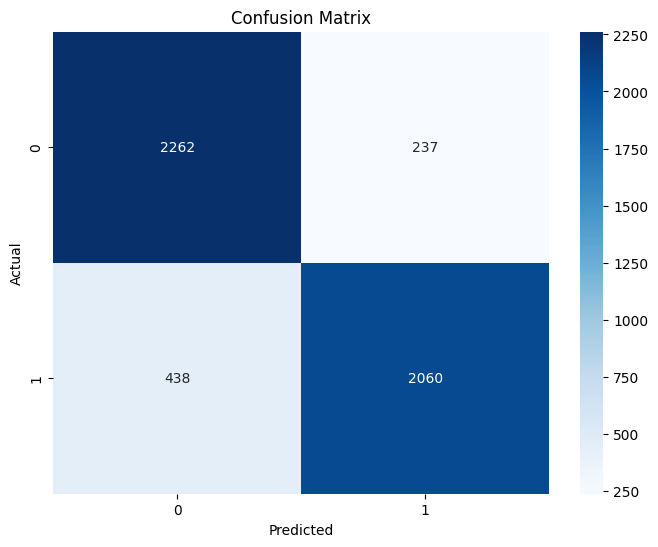

<Figure size 800x600 with 0 Axes>

In [13]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

test_loss, test_acc = model.evaluate(X_test, y_test)
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
#plt.close()



# Train vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
plt.close()

# Train vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
#plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title(f'ROC Curve - {name}')
plt.legend(loc="lower right")
#plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
#plt.close()

In [8]:
x_train = X_train
x_test = X_test
y_train = y_train
y_test = y_test
model = my_cnn()
name = "my"
param = "2000"

start_time = time.time()
history = model.fit(x_train, y_train, epochs=70, batch_size=32,
                validation_split=0.2, verbose=1, callbacks=[early_stopping])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")
test_loss, test_acc = model.evaluate(x_test, y_test)
loss, acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
y_prob = model.predict(x_test)
y_pred = (y_prob > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_matrix.png")
plt.close()

# Zapisz model
model.save(f'/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_model.h5')

file_path = f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_history.pkl"
with open(file_path, 'wb') as f:
  pickle.dump(history.history, f)

# Train vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_loss.png")
plt.close()

# Train vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_train_val_accuracy.png")
plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(f'ROC Curve - {name}')
plt.legend(loc="lower right")
plt.savefig(f"/content/drive/MyDrive/Master - A/2_fig/{param}_{name}_roc_curve.png")
plt.close()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7313 - loss: 0.5250 - val_accuracy: 0.8252 - val_loss: 0.3885
Epoch 2/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.8436 - loss: 0.3642 - val_accuracy: 0.8257 - val_loss: 0.4021
Epoch 3/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.8658 - loss: 0.3198 - val_accuracy: 0.8504 - val_loss: 0.3497
Epoch 4/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8866 - loss: 0.2741 - val_accuracy: 0.7031 - val_loss: 0.6275
Epoch 5/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8814 - loss: 0.2785 - val_accuracy: 0.8814 - val_loss: 0.3040
Epoch 6/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9242 - loss: 0.1860 - val_accuracy: 0.8392 - val_loss: 0.3908
Epoch 7/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9359 - loss: 0.1603 - val_accuracy: 0.8669 - val_loss: 0.4129
Epoch 8/70
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9609 - loss: 0.0987 - 

NameError: name 'roc_curve' is not defined

In [9]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[2260,  239],
       [ 334, 2164]])